In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from tqdm import tqdm
import os
import glob as gb
import random as rn
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop


# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [10]:
x=[]
z=[]
img_size=150
daisy='D:/dl/flowering/flowers/daisy'
sunflower='D:/dl/flowering/flowers/sunflower'
tulip='D:/dl/flowering/flowers/tulip'
dandi='D:/dl/flowering/flowers/dandelion'
rose='D:/dl/flowering/flowers/rose'

In [11]:
def assign_label(img,flower_type):
    return flower_type

In [12]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path=os.path.join(DIR,img)
        img=cv2.imread(path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(img_size,img_size))
        x.append(np.array(img))
        z.append(str(label))

In [13]:
make_train_data('Daisy',daisy)
len(x)

100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:27<00:00, 28.28it/s]


764

In [14]:
make_train_data('SunFlower',sunflower)
len(x)

100%|████████████████████████████████████████████████████████████████████████████████| 733/733 [00:35<00:00, 20.73it/s]


1497

In [15]:
make_train_data('Tulip',tulip)
len(x)

100%|████████████████████████████████████████████████████████████████████████████████| 984/984 [00:37<00:00, 25.90it/s]


2481

In [16]:
make_train_data('Dandelion',dandi)
len(x)

100%|██████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:48<00:00, 21.60it/s]


3533

In [17]:
make_train_data('Rose',rose)
len(x)

100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [00:29<00:00, 26.36it/s]


4317

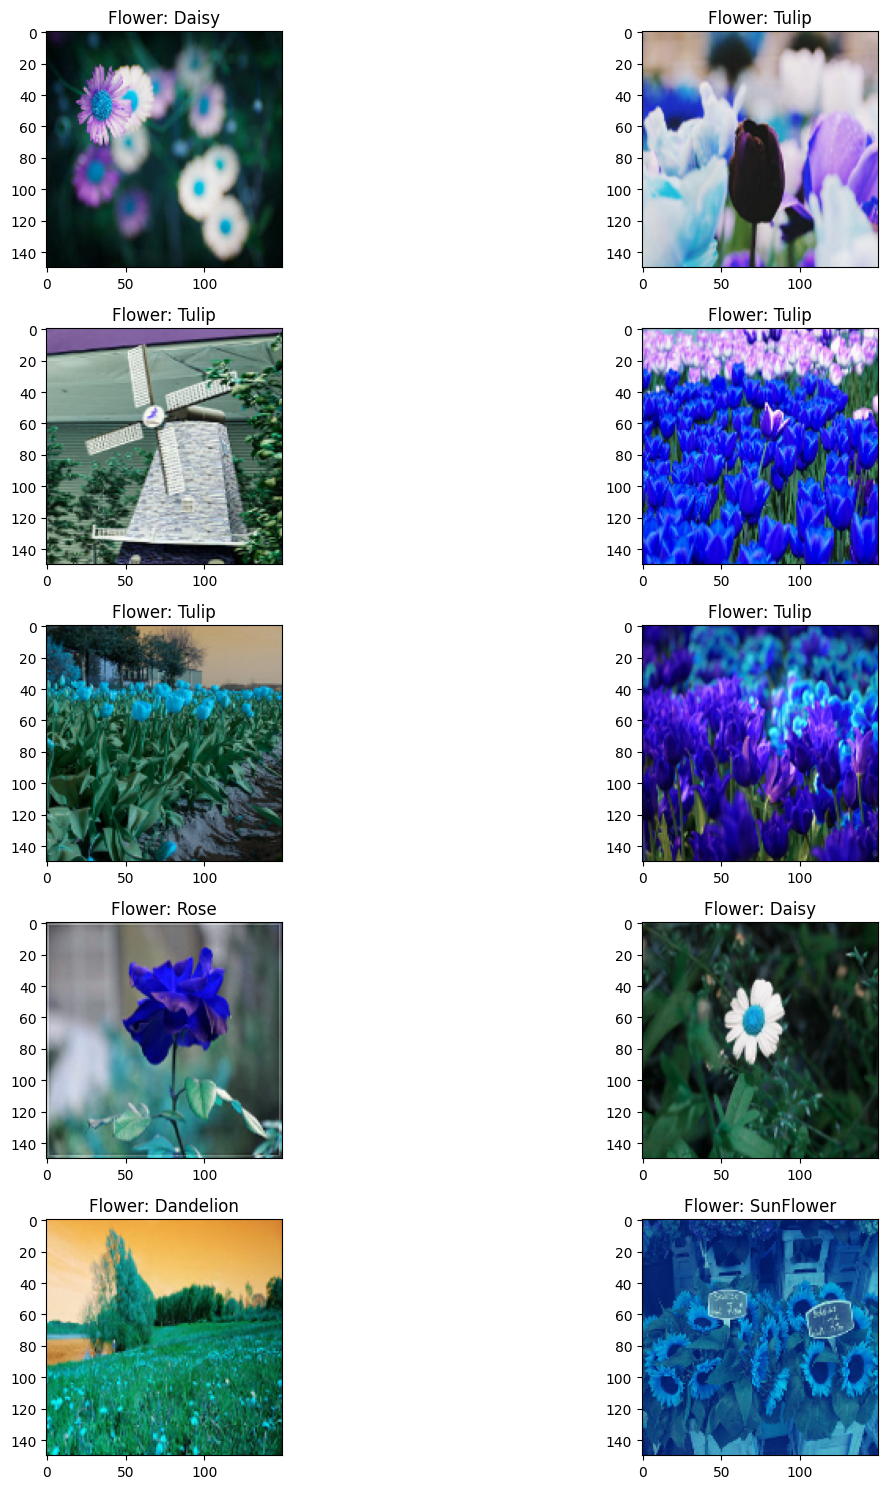

In [18]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(z))
        ax[i,j].imshow(x[l])
        ax[i,j].set_title('Flower: '+z[l])
        
plt.tight_layout()

In [19]:
le=LabelEncoder()
y=le.fit_transform(z)
y=to_categorical(y,5)
x=np.array(x)
#scale for x
x=x/255

In [20]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [21]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [22]:
x_train[0].shape

(150, 150, 3)

In [23]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [24]:
batch_size=128
epochs=10

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [25]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

In [28]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

C:\Users\Mahi's Pc\AppData\Local\Temp\ipykernel_612\1698440258.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/10
25/25 [==============================] - 121s 5s/step - loss: 1.4513 - accuracy: 0.3409 - val_loss: 1.2121 - val_accuracy: 0.4546
Epoch 2/10
25/25 [==============================] - 110s 4s/step - loss: 1.2333 - accuracy: 0.4741 - val_loss: 1.0865 - val_accuracy: 0.5296
Epoch 3/10
25/25 [==============================] - 108s 4s/step - loss: 1.1098 - accuracy: 0.5555 - val_loss: 0.9968 - val_accuracy: 0.6083
Epoch 4/10
25/25 [==============================] - 108s 4s/step - loss: 1.0292 - accuracy: 0.6005 - val_loss: 0.9601 - val_accuracy: 0.6083
Epoch 5/10
25/25 [==============================] - 105s 4s/step - loss: 0.9734 - accuracy: 0.6285 - val_loss: 0.9739 - val_accuracy: 0.6111
Epoch 6/10
25/25 [==============================] - 104s 4s/step - loss: 0.9183 - accuracy: 0.6539 - val_loss: 0.8542 - val_accuracy: 0.6620
Epoch 7/10
25/25 [==============================] - 340s 14s/step - loss: 0.8854 - accuracy: 0.6603 - val_loss: 0.9402 - val_accuracy: 0.6306
Epoch 8/10
2

In [29]:
model.evaluate(x_test,y_test)

34/34 [==============================] - 8s 244ms/step - loss: 0.7384 - accuracy: 0.7056


[0.7384371161460876, 0.7055555582046509]

In [31]:
y_test_predict = model.predict(x_test)

34/34 [==============================] - 6s 173ms/step


In [32]:
y_test_predict = np.argmax(y_test_predict,axis=1)

In [34]:
names = ['daisy', 'sunflower', 'tulip', 'dandeline', 'rose']

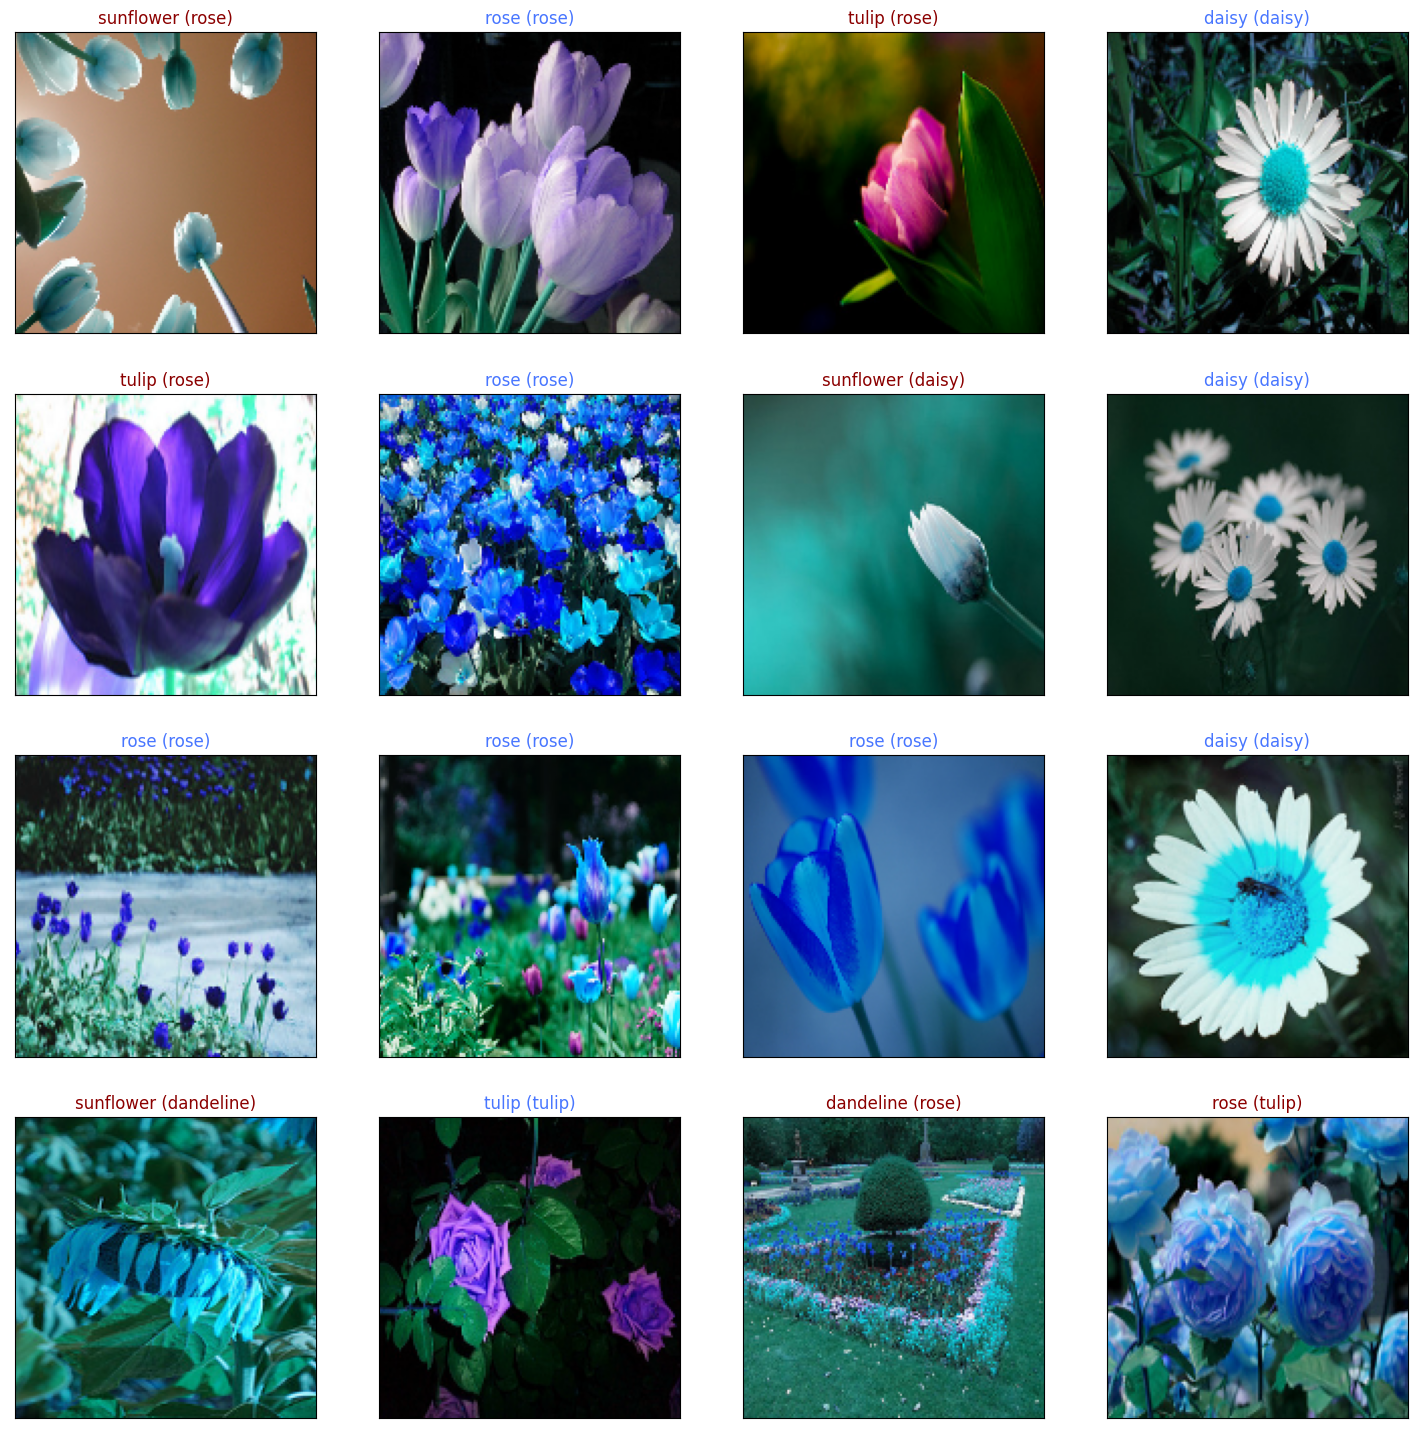

In [35]:
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

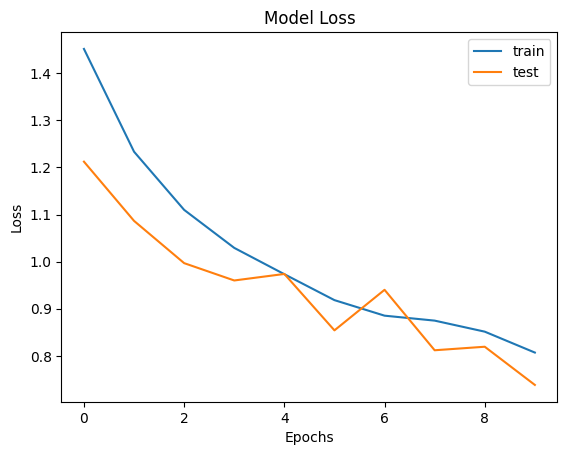

In [36]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

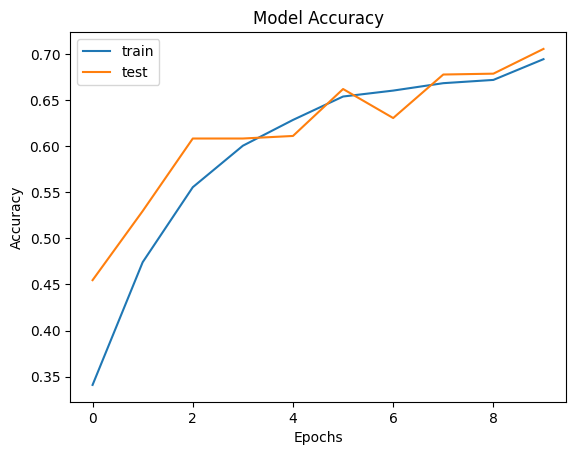

In [37]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()